(64, 320, 320)
(192, 260, 320)


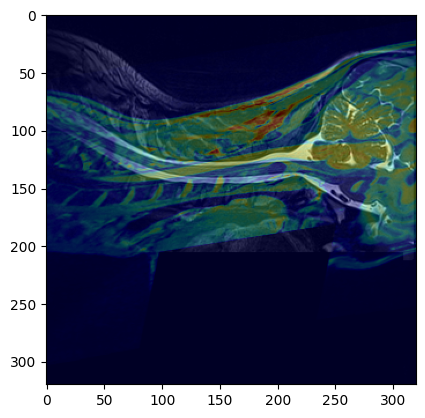

After registration:  (64, 320, 320) (64, 320, 320)


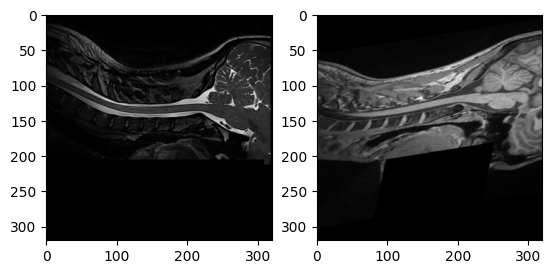

After resizing:  (256, 256) (256, 256)


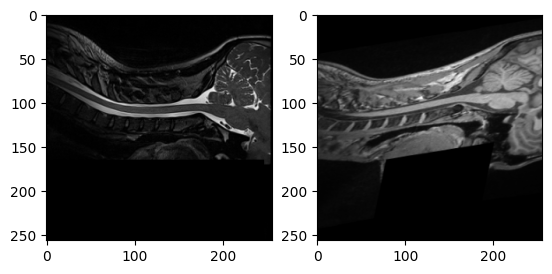

After normalization:  (256, 256) (256, 256)


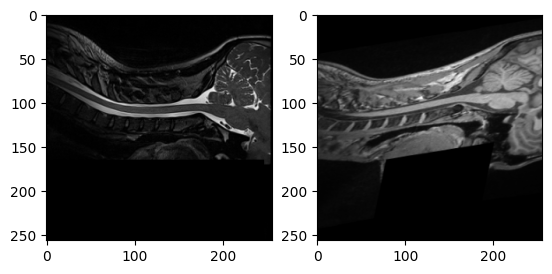

After CLAHE:  (256, 256) (256, 256)


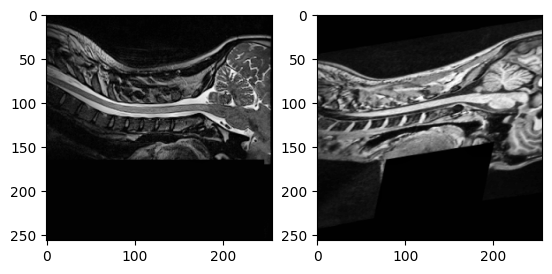

In [1]:
import nibabel as nib
import numpy as np
import os
import matplotlib.pyplot as plt
import SimpleITK as sitk
import cv2
import subprocess

# Load images in NIFTI format from path

path_to_images = 'C:/Users/bianc/Documents/GitHub/data-multi-subject/sub-amu01/anat' 
t2w_image = os.path.join(path_to_images, 'sub-amu01_T2w.nii.gz')
t1w_image = os.path.join(path_to_images, 'sub-amu01_T1w.nii.gz')

test_slice = 30


def load_image(path_to_image):
    image = nib.load(path_to_image)
    image_data = image.get_fdata()
    return image_data

t2w_image_data = load_image(t2w_image)
t1w_image_data = load_image(t1w_image)

# Get the shape of the images
print(t2w_image_data.shape)
print(t1w_image_data.shape)

# Visualize the images
def visualize_image(image_data):
    # image_data[0,:,:] is the first slice of the image in the sagittal plane, 
    # image_data[:,0,:] is the first slice in the coronal plane, 
    # image_data[:,:,0] is the first slice in the axial plane
    plt.imshow(image_data[test_slice,:,:], cmap='gray')
    plt.show()

# visualize_image(t2w_image_data)
# visualize_image(t1w_image_data)

# Register the images using SimpleITK
def register_images(fixed_image_data, moving_image_data):
    # Convert numpy arrays to SimpleITK images
    fixed_image = sitk.GetImageFromArray(fixed_image_data)
    moving_image = sitk.GetImageFromArray(moving_image_data)

    # Initialize the registration method
    registration_method = sitk.ImageRegistrationMethod()

    # Set the optimizer
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100)

    # Similarity metric setting
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)

    # Interpolator
    registration_method.SetInterpolator(sitk.sitkLinear)

    # Affine transform
    initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                          moving_image, 
                                                          sitk.AffineTransform(fixed_image.GetDimension()))
    registration_method.SetInitialTransform(initial_transform)

    # Execute the registration
    final_transform = registration_method.Execute(fixed_image, moving_image)

    # Transform the moving image to align with the fixed image
    aligned_image = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

    # Visualize the aligned image as a semi-transparent overlay on the fixed image
    plt.imshow(sitk.GetArrayFromImage(fixed_image)[test_slice,:,:], cmap='gray')
    plt.imshow(sitk.GetArrayFromImage(aligned_image)[test_slice,:,:], cmap='jet', alpha=0.3)
    plt.show()

    return sitk.GetArrayFromImage(aligned_image)

# Registration using Spinal Cord Toolbox
get_registered_images = ['sct_register_multimodal', '-i', t2w_image, '-d', t1w_image, '-param', 'algo=dl']
subprocess.run(["get_registered_images"], shell=True)

# Register the T1w image to the T2w image
aligned_t1w_image_data = register_images(t2w_image_data, t1w_image_data)

# Visualize the source image (T2w) and the target image (T1w) after registration side by side
def visualize_images(image_data_1, image_data_2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image_data_1, cmap='gray')
    ax2.imshow(image_data_2, cmap='gray')
    plt.show()


print("After registration: ", t2w_image_data.shape, aligned_t1w_image_data.shape)

visualize_images(t2w_image_data[test_slice,:,:], aligned_t1w_image_data[test_slice,:,:])

# Extract matching slices from the images to create a 2D dataset
def extract_matching_slices(image_data_1, image_data_2, slice = test_slice):
    image_data_1_2d = image_data_1[slice,:,:]
    image_data_2_2d = image_data_2[slice,:,:]
    return image_data_1_2d, image_data_2_2d

t2w_image_data_2d, aligned_t1w_image_data_2d = extract_matching_slices(t2w_image_data, aligned_t1w_image_data)

# Rest of the preprocessing steps

# Resize the 2D images to 256x256
def resize_image(image, size=(256, 256)):
    resized_image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
    return resized_image

t2w_image_data_2d_resized = resize_image(t2w_image_data_2d)
aligned_t1w_image_data_2d_resized = resize_image(aligned_t1w_image_data_2d)

print("After resizing: ", t2w_image_data_2d_resized.shape, aligned_t1w_image_data_2d_resized.shape)

# Visualize the resized images
visualize_images(t2w_image_data_2d_resized, aligned_t1w_image_data_2d_resized)

# Normalize the images
def normalize_image(image_data):
    image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))
    return image_data

# Normalize the resized images between 0 and 1
def normalize_image_between_0_and_1(image_data):
    image_data = image_data / 255
    return image_data

t2w_image_data_2d_resized_normalized = normalize_image_between_0_and_1(t2w_image_data_2d_resized)
aligned_t1w_image_data_2d_resized_normalized = normalize_image_between_0_and_1(aligned_t1w_image_data_2d_resized)

print("After normalization: ", t2w_image_data_2d_resized_normalized.shape, aligned_t1w_image_data_2d_resized_normalized.shape)

# Save images to disk
def save_image(image_data, path_to_save):
    cv2.imwrite(path_to_save, image_data)

path_to_save_t2w = 'sub-amu01_T2w_2d_resized_normalized.png'
path_to_save_t1w = 'sub-amu01_T1w_2d_resized_normalized.png'

save_image(t2w_image_data_2d_resized_normalized, path_to_save_t2w)
save_image(aligned_t1w_image_data_2d_resized_normalized, path_to_save_t1w)

# Visualize the normalized images
visualize_images(t2w_image_data_2d_resized_normalized, aligned_t1w_image_data_2d_resized_normalized)

# Optional step: Apply histogram equalization to the images
def apply_histogram_equalization(image_data):
    image_data = (image_data * 255).astype(np.uint8)
    image_data = cv2.equalizeHist(image_data)
    return image_data

# Optional step: Apply CLAHE to the images
def apply_clahe(image_data, bit_depth=8):
    if bit_depth == 8:
        # Convert to 0-255 and uint8 type
        image_data = (image_data * 255).astype(np.uint8)
    elif bit_depth == 16:
        # Convert to 0-65535 and uint16 type
        image_data = (image_data * 65535).astype(np.uint16)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    image_data = clahe.apply(image_data)
    return image_data

# Optional step: Apply Gaussian smoothing to the images
def apply_gaussian_smoothing(image_data):
    image_data = cv2.GaussianBlur(image_data, (5,5), 0)
    return image_data

# Optional step: Apply Sobel filter to the images
def apply_sobel_filter(image_data):
    sobel_x = cv2.Sobel(image_data, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image_data, cv2.CV_64F, 0, 1, ksize=3)
    sobel_xy = cv2.addWeighted(sobel_x, 0.5, sobel_y, 0.5, 0)
    return sobel_xy

# Optional step : Skull stripping

# Apply the  Gaussian smoothing to the images
# t2w_image_data_2d_resized_normalized_preprocessed = apply_gaussian_smoothing(t2w_image_data_2d_resized_normalized)
# aligned_t1w_image_data_2d_resized_normalized_preprocessed = apply_gaussian_smoothing(aligned_t1w_image_data_2d_resized_normalized)

# Apply the histogram equalization to the images
t2w_image_data_2d_resized_normalized_hist_eq = apply_histogram_equalization(t2w_image_data_2d_resized_normalized)
aligned_t1w_image_data_2d_resized_normalized_hist_eq = apply_histogram_equalization(aligned_t1w_image_data_2d_resized_normalized)

# Apply the CLAHE to the images
t2w_image_data_2d_resized_normalized_clahe = apply_clahe(t2w_image_data_2d_resized_normalized, bit_depth=8)
aligned_t1w_image_data_2d_resized_normalized_clahe = apply_clahe(aligned_t1w_image_data_2d_resized_normalized, bit_depth=8)

# Apply the Sobel filter to the images
# t2w_image_data_2d_resized_normalized_preprocessed = apply_clahe(t2w_image_data_2d_resized_normalized, bit_depth=8)
# aligned_t1w_image_data_2d_resized_normalized_preprocessed = apply_clahe(aligned_t1w_image_data_2d_resized_normalized, bit_depth=8)

# print("After histogram equalization: ", t2w_image_data_2d_resized_normalized_hist_eq.shape, t2w_image_data_2d_resized_normalized_hist_eq.shape)

# Visualize the preprocessed images
# visualize_images(t2w_image_data_2d_resized_normalized_hist_eq, aligned_t1w_image_data_2d_resized_normalized_hist_eq)

print("After CLAHE: ", t2w_image_data_2d_resized_normalized_clahe.shape, aligned_t1w_image_data_2d_resized_normalized_clahe.shape)

visualize_images(t2w_image_data_2d_resized_normalized_clahe, aligned_t1w_image_data_2d_resized_normalized_clahe)